[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pycroscopy/pycroscopy/blob/main/jupyter_notebooks/Analysis_Core_Loss.ipynb)


# <center> A processing and analytics system for microscopy data workflows: the Pycroscopy ecosystem of packages

<center><font size = 3> R. Vasudevan<sup>1,*</sup>, S. M. Valleti,<sup>2</sup> M. Ziatdinov,<sup>1,3</sup> G. Duscher,<sup>4,**</sup> and S. Somnath<sup>5,6</sup> </font></center>

<sup>1</sup>Center for Nanophase Materials Sciences, Oak Ridge National Laboratory \
<sup>2</sup>Bredesen Center for Interdisciplinary Research, University of Tennessee, Knoxville \
<sup>3</sup>Computational Sciences and Engineering Division, Oak Ridge National Laboratory \
<sup>4</sup>Department of Materials Science and Engineering, University of Tennessee, Knoxville \
<sup>5</sup>National Center for Computational Sciences, Oak Ridge National Laboratory \
<sup>6</sup>Current affiliation: McKinsey Consulting Group

## <left> Analysis of Core Loss Spectra
by Gerd Duscher, 2020

Microscopy Facilities
Joint Institute of Advanced Materials
The University of Tennessee, Knoxville
    
Model based analysis and quantification of data acquired with transmission electron microscopes


## Content

Quantitative determination of chemical composition from a core-loss EELS spectrum


Relavant notebooks in course [MSE 672: Introduction to TEM]()  give an in depth explanation of the method.

Please cite:

[M. Tian et  al. *Measuring the areal density of nanomaterials by electron energy-loss spectroscopy*
Ultramicroscopy Volume 196, 2019, pages 154-160](https://doi.org/10.1016/j.ultramic.2018.10.009)

as a reference of this quantification method.

## Prerequesites
This notebook will only run with  ``version 0.2022.6.0`` or higher.

### Install missing packages
This can take a while for the first time. This code will have to run at least once on you computer or colab session.

In [1]:
# pyTEMlib and other requried packages setup 
!pip install -U pyTEMlib pycroscopy wget pyqt5

print('done')

done


In [1]:
import wget
wget.download(url='https://zenodo.org/record/8190744/files/EELS_STO.dm3?download=1',
              out = 'EELS_STO.dm3')

'EELS_STO (1).dm3'

### Load the relevant packages

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pylab as plt
%gui qt

import sys
sys.path.insert(0, '../..')
import pyTEMlib
import pyTEMlib.file_tools as ft     # File input/ output library
import pyTEMlib.image_tools as it
import pyTEMlib.eels_tools  as eels        # EELS methods 

import pyTEMlib.interactive_eels as ieels  # Dialogs for EELS input and quantification

# For archiving reasons it is a good idea to print the version numbers out at this point
print('pyTEM version: ', pyTEMlib.__version__)

__notebook__ = 'analyse_core_loss'
__notebook_version__ = '2022_09_24'

You don't have igor2 installed.     If you wish to open igor files, you will need to install it     (pip install igor2) before attempting.
Symmetry functions of spglib enabled
pyTEM version:  0.2023.8.0


## Load and plot a spectrum

As an example we load the spectrum **EELS_STO.dm3** from the *data* folder.

Please see [Loading an EELS Spectrum](LoadEELS.ipynb) for details on storage and plotting.

First a dialog to select a file will apear.

Then the spectrum plot and ``Spectrum Info`` dialog will appear, in which we set the experimental parameters.

Please use the ``Set Energy Scale`` button to change the energy scale. When pressed a new dialog and a cursor will appear in which one is able to set the energy scale based on known features in the spectrum.


Dropdown(description='select dataset:', options=('Channel_000: 01-EELS Acquire_STO',), value='Channel_000: 01-…

<IPython.core.display.Javascript object>


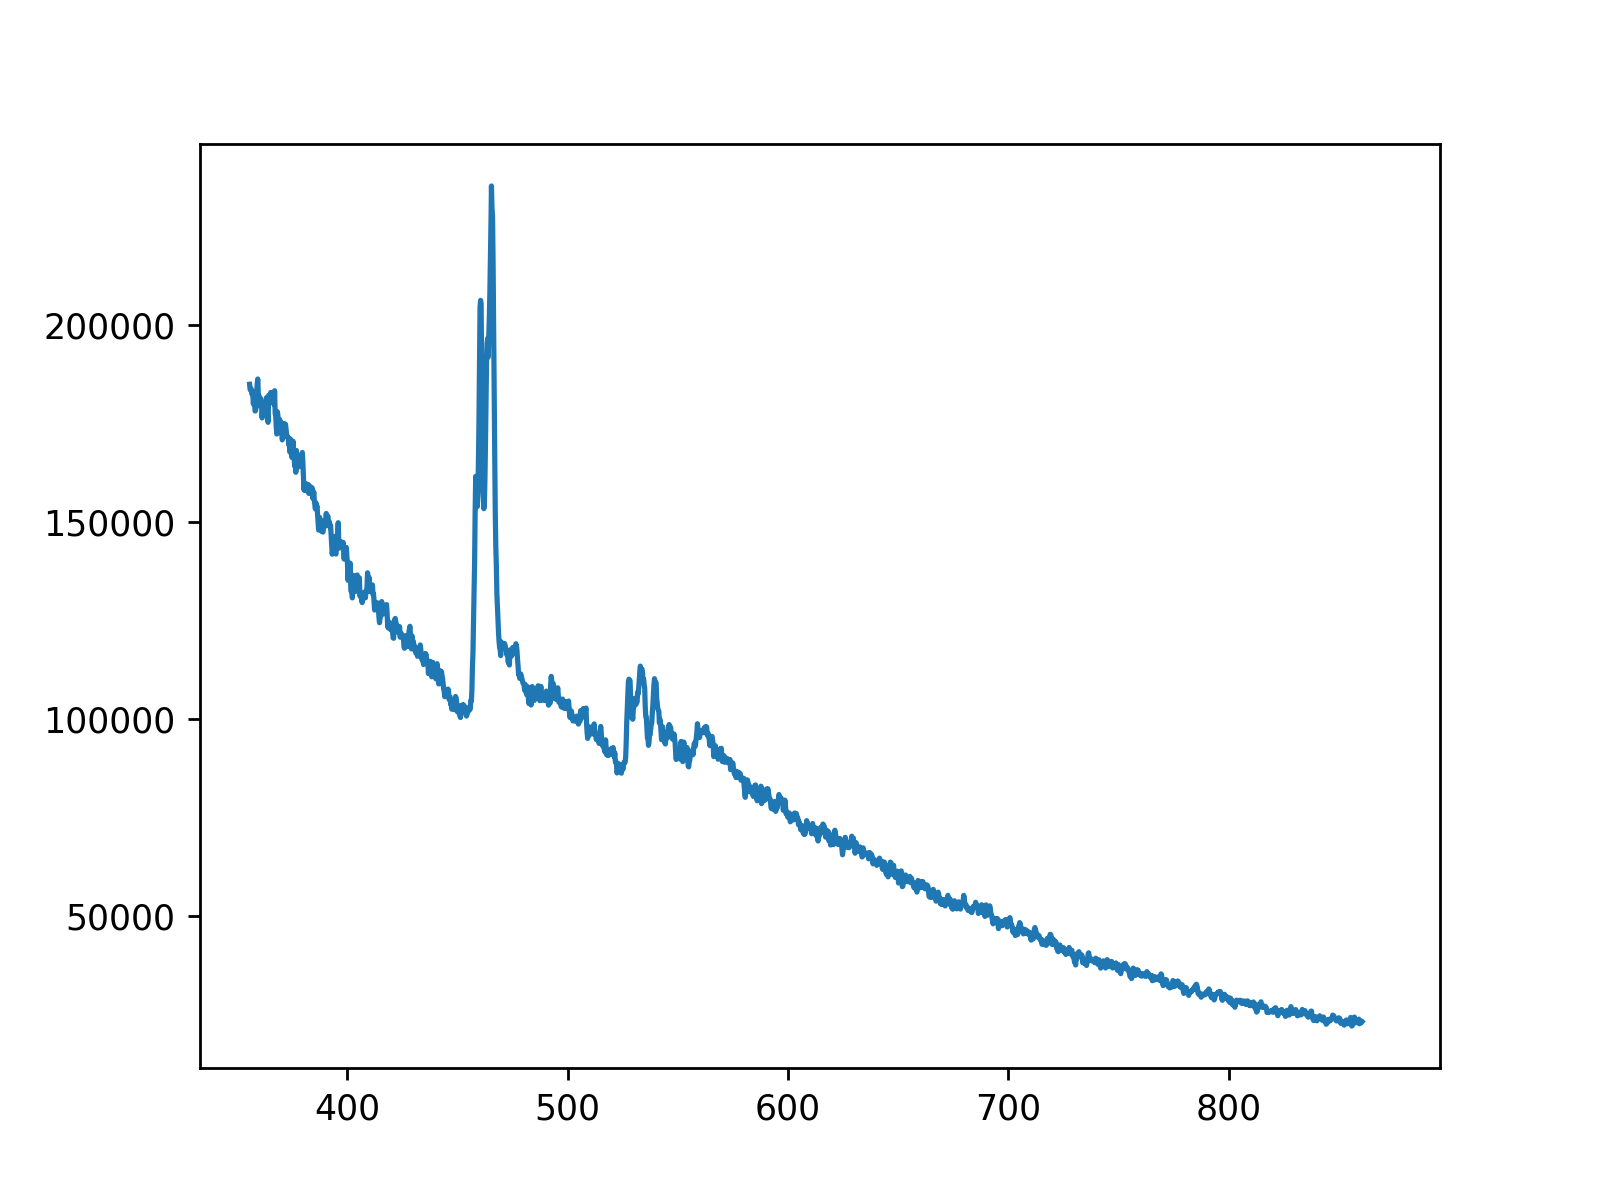

In [2]:
filename='EELS_STO.dm3'

datasets=  ft.open_file(filename=filename)
chooser = ft.ChooseDataset(datasets)

dataset = chooser.dataset

if dataset.data_type.name in ['SPECTRUM', 'SPECTRAL_IMAGE']:
    info = ieels.InfoDialog(datasets, chooser.key)
else:
    print('We really need a spectrum here')
    dataset.plot()

In [4]:
dataset.metadata

{'experiment': {'single_exposure_time': 2.0,
  'exposure_time': 20.0,
  'number_of_frames': 10,
  'collection_angle': 33.0,
  'convergence_angle': 30.0,
  'acceleration_voltage': 200000.0,
  'offset': 355.5756578947369,
  'dispersion': 0.2467105263157805,
  'binning': 1,
  'conversion': 1.0,
  'flux_ppm': -1.0,
  'flux_unit': 'counts',
  'current': 1.0,
  'SI_bin_x': 1,
  'SI_bin_y': 1},
 'filename': 'EELS_STO.dm3'}

In [5]:
chooser = ft.ChooseDataset(datasets)

Dropdown(description='select dataset:', options=('Channel_000: 01-EELS Acquire_STO',), value='Channel_000: 01-…

<IPython.core.display.Javascript object>


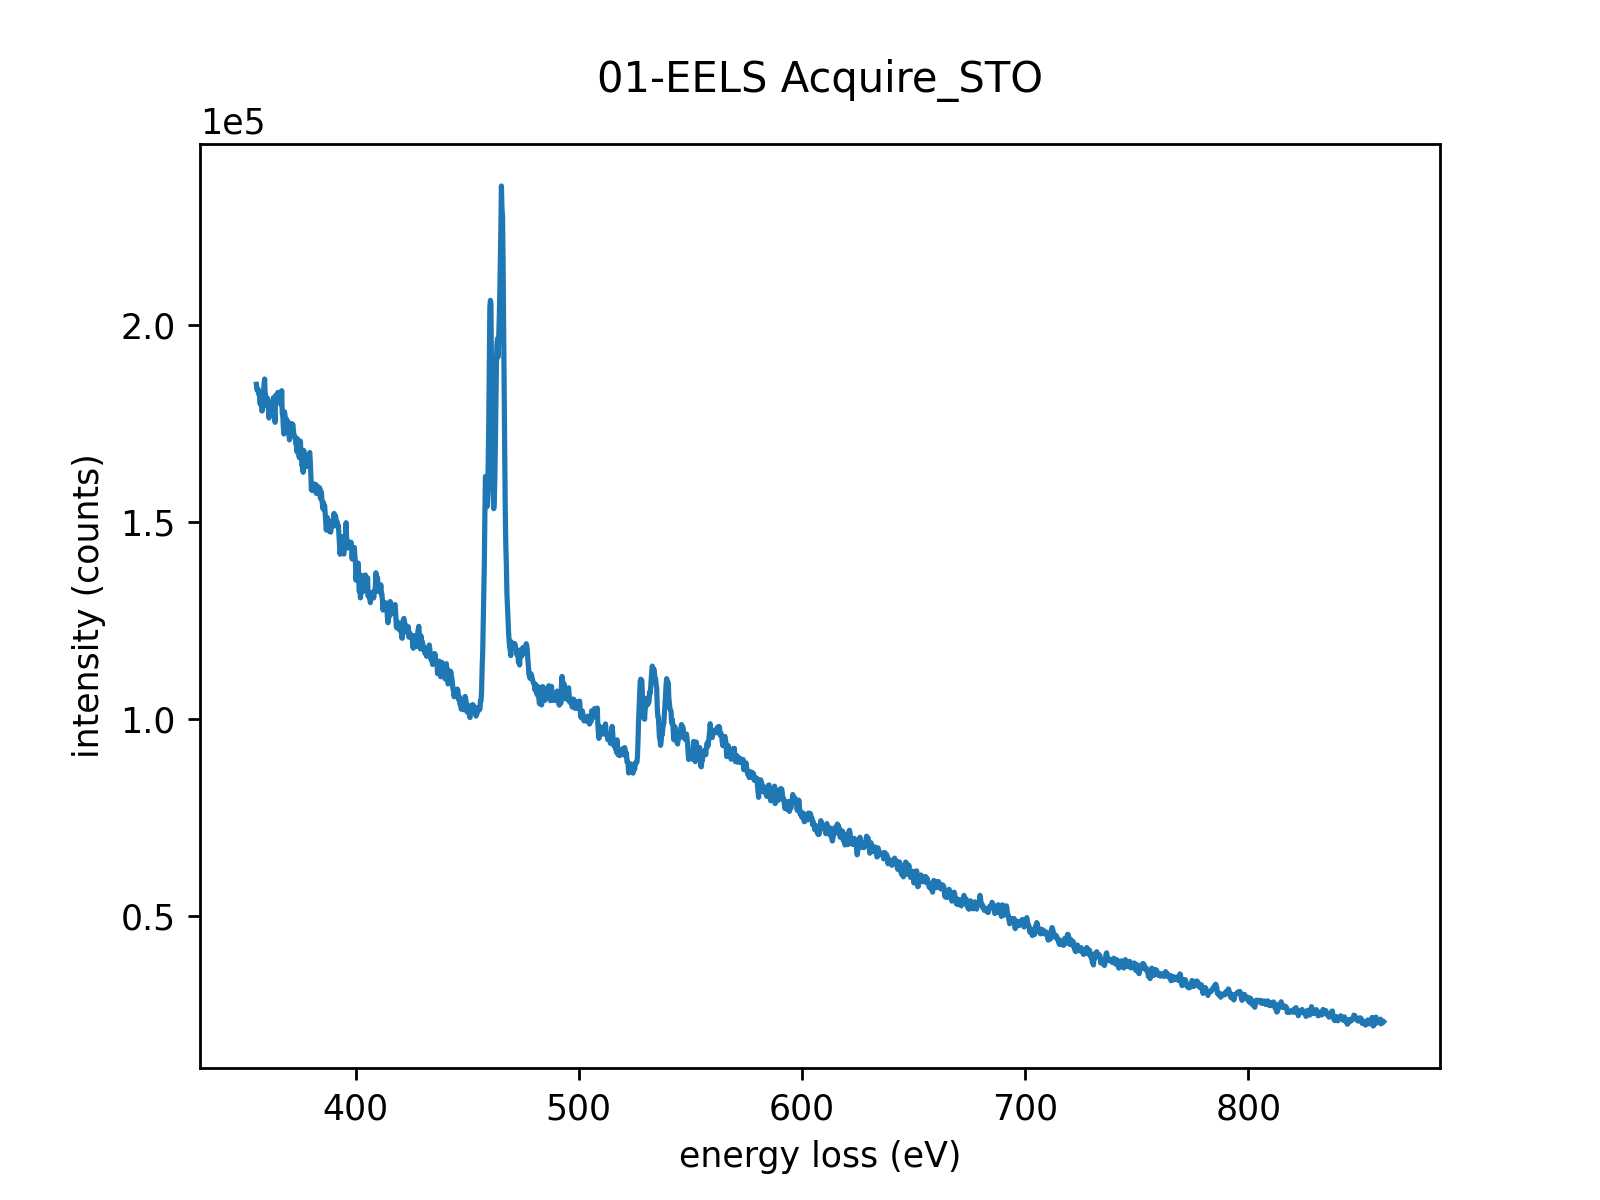

In [6]:
dataset = chooser.dataset
view = dataset.plot()

## Chemical Composition 
The fit of the cross-section and background to the spectrum results in the chemical composition. If the calibration is correct this composition is given as areal density in atoms/nm$^2$


###  Fit of Data
A dialog window will open, enter the elements first (0 will open a periodic table) and press 
``Fit Composition`` button (bottom right). Adjust parameters as needed and check fit by pressing the ``Fit Composition`` button again.

Select the ``Region`` checkbox to see which parts of the spectrum you choose to fit.

Changing the multiplier value will make a simulation of your spectrum.

The ``InfoDialog``, if open, still works to change experimental parameters and the energy scale.

<IPython.core.display.Javascript object>


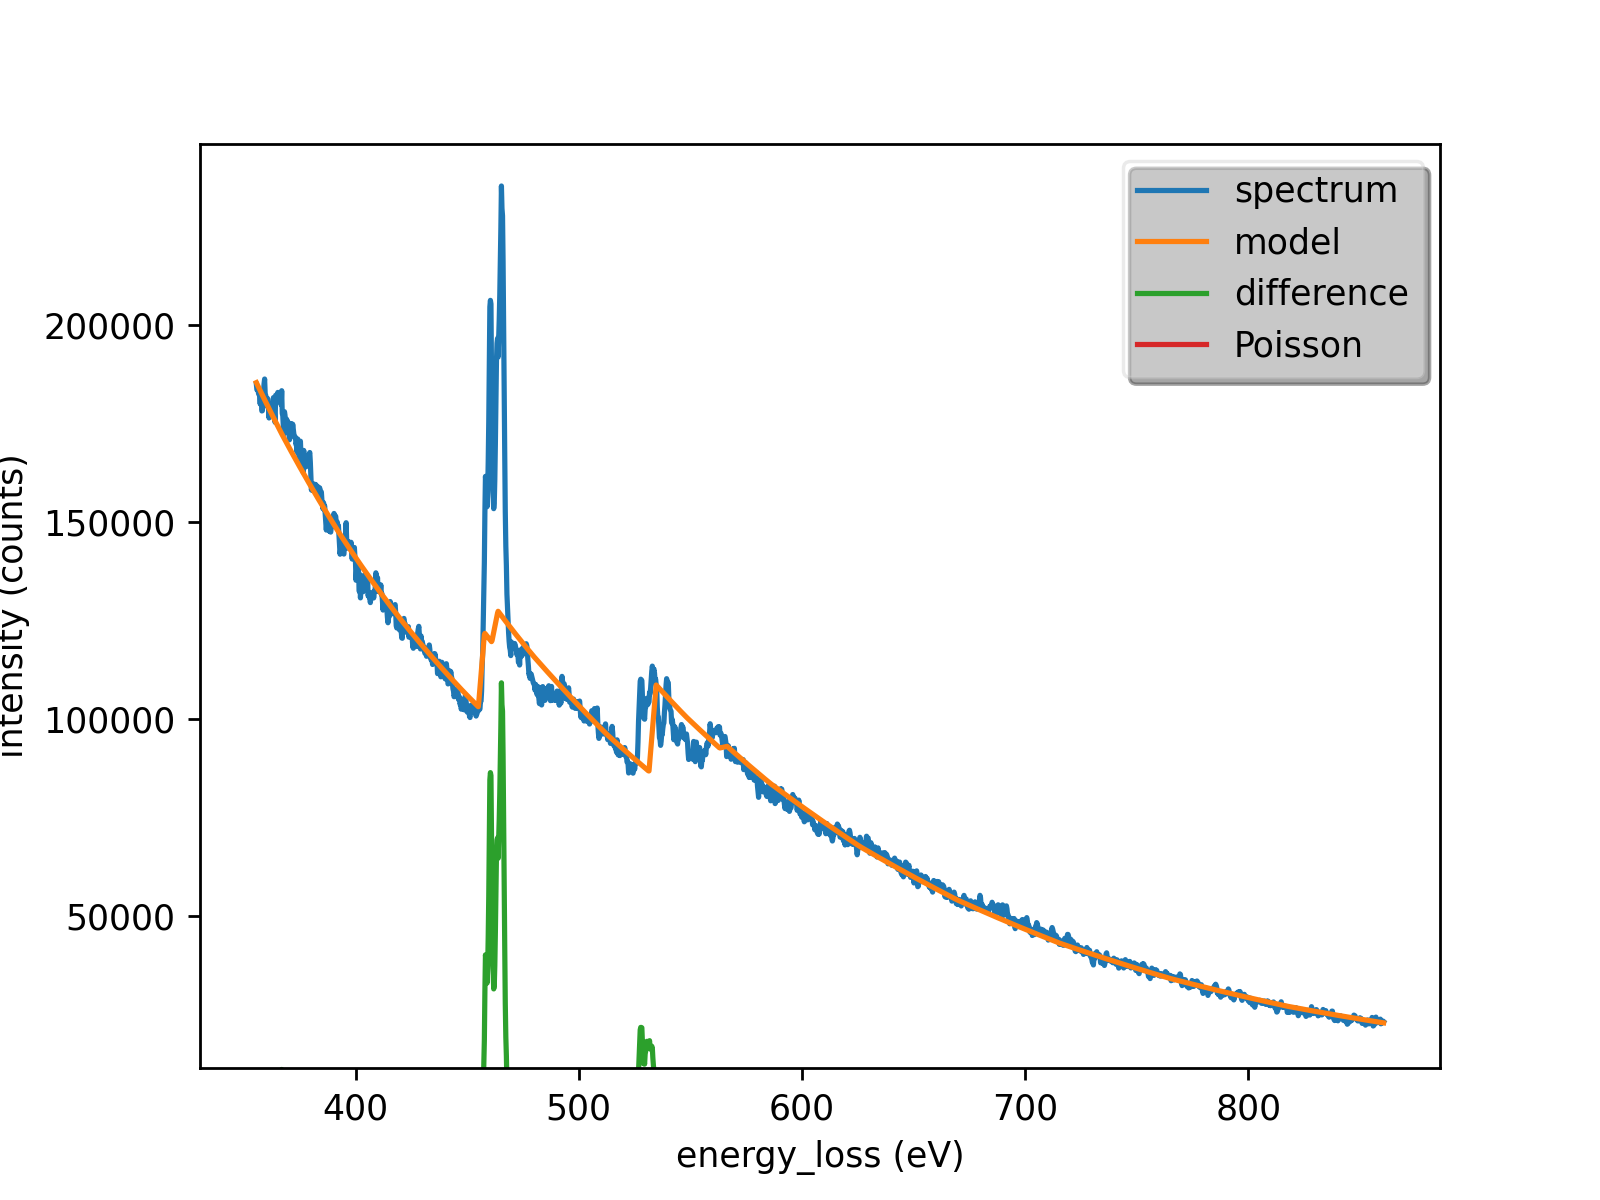

In [7]:
composition = ieels.CompositionDialog(dataset)

### Output of Results

In [8]:
edges = dataset.metadata['edges']
element = []
areal_density = []
for key, edge in edges.items():
    if key.isdigit():
        element.append(edge['element'])
        areal_density.append(edge['areal_density'])

print('Relative chemical composition of ', dataset.title)
for i in range(len(element)):
    print(f'{element[i]}: {areal_density[i]/np.sum(areal_density)*100:.1f} %')
    
saved_edges_metadata = edges

Relative chemical composition of  01-EELS Acquire_STO
Ti: 19.6 %
O: 80.4 %


### Log Data
We write all the data to the hdf5 file associated with our dataset.

In our case that is only the ``metadata``, in which we stored the ``experimental parameters`` and the ``fitting parameters and result``.

In [9]:
datasets['Log_000'] = dataset.metadata

## ELNES
The electron energy-loss near edge structure is determined by fititng the spectrum after quantification model subtraction. 

First smooth the spectrum (only 0 iteration available at this time) and then 
find the number of peaks you want (Can be repeated as oftern as one wants).

Please note that the peaks do not necessarily have a physcial meaning as there are peaks with 
positive and negative amplitudes. The goal is to get a smooth representation of the spectrum.
A difference of a good fit and the data should result in a residual of noise only. To achieve such a good fit, the careful setting of the edge onset is important.


<IPython.core.display.Javascript object>


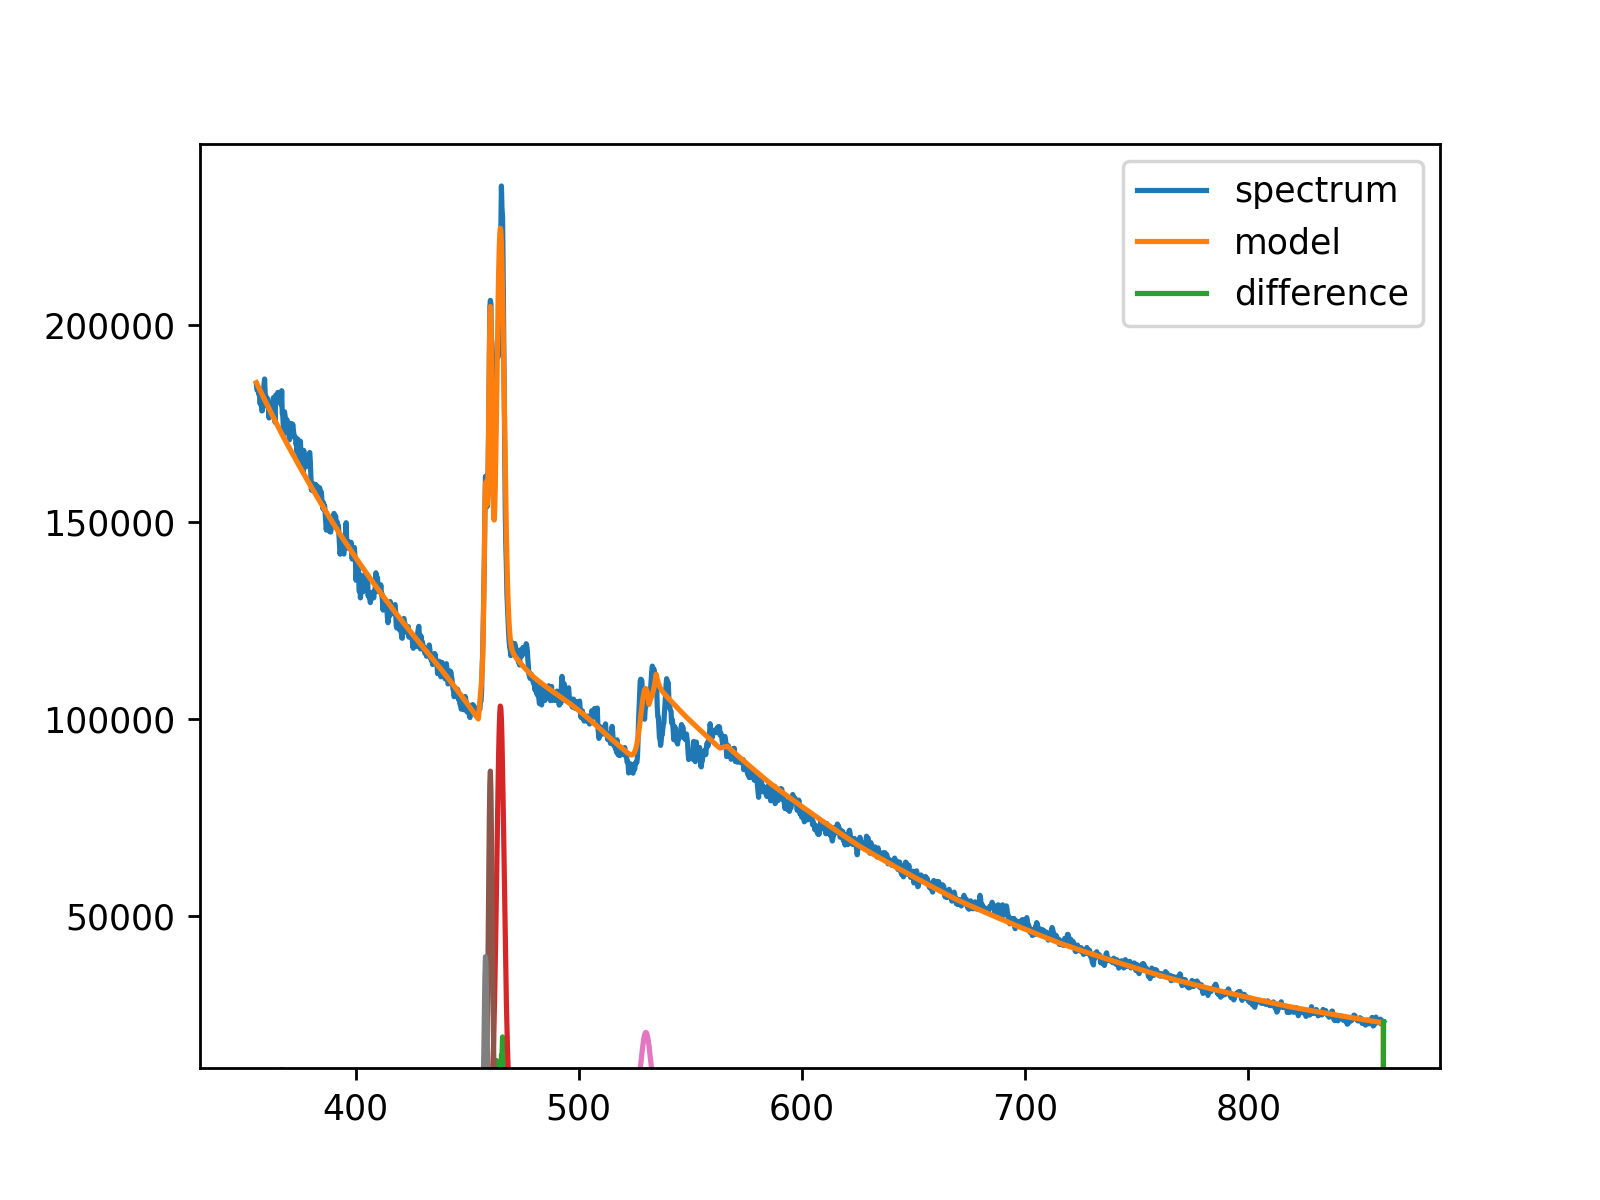

In [11]:
peak_dialog = ieels.PeakFitDialog(dataset)

### Output

In [12]:
areas = []
for p, peak in peak_dialog.peaks['peaks'].items():
    area = np.sqrt(2* np.pi)* peak['amplitude'] * np.abs(peak['width'] / np.sqrt(2 *np.log(2))) 
    areas.append(area)
    if 'associated_edge' not in peak:
        peak['associated_edge']= ''
    print(f"peak  {p}: position: {peak['position']:7.1f}, area: {area:12.3f} associated edge: {peak['associated_edge']}")
#print(f'\n M4/M5 peak 2 to peak 1 ratio: {(areas[1])/areas[0]:.2f}')

peak  0: position:   464.9, area:   848348.772 associated edge: Ti-L2
peak  1: position:   472.5, area:  -456552.999 associated edge: Ti-L2
peak  2: position:   460.4, area:   352324.552 associated edge: Ti-L3
peak  3: position:   530.1, area:   234492.429 associated edge: 
peak  4: position:   458.3, area:   112956.226 associated edge: Ti-L3


### Log Data

In [13]:
datasets['Log_001'] = dataset.metadata

In [14]:
datasets['Log_001']

{'experiment': {'single_exposure_time': 2.0,
  'exposure_time': 20.0,
  'number_of_frames': 10,
  'collection_angle': 33.0,
  'convergence_angle': 30.0,
  'acceleration_voltage': 200000.0,
  'offset': 355.5756578947369,
  'dispersion': 0.2467105263157805,
  'binning': 1,
  'conversion': 1.0,
  'flux_ppm': -1.0,
  'flux_unit': 'counts',
  'current': 1.0,
  'SI_bin_x': 1,
  'SI_bin_y': 1},
 'filename': 'EELS_STO.dm3',
 'edges': {'0': {'z': 22,
   'symmetry': 'L3',
   'element': 'Ti',
   'onset': 455.5,
   'end_exclude': 505.5,
   'start_exclude': 450.5,
   'all_edges': {'L3': {'onset': 455.5},
    'L2': {'onset': 461.5},
    'L1': {'onset': 563.6999999999999}},
   'chemical_shift': 0.0,
   'areal_density': 8059086352923.819,
   'original_onset': 455.5,
   'data': array([9.16143038e-10, 9.14103697e-10, 9.12064355e-10, ...,
          4.72986982e-10, 4.72426338e-10, 4.71865693e-10]),
   'X_section_type': 'XRPA',
   'X_section_source': 'pyTEMlib'},
  'model': {'background': array([171927.461